In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Add the directory to Python path
import sys
sys.path.append('/content/drive/MyDrive')

from scipy.integrate import quad

Mounted at /content/drive


In [ ]:
%run /content/drive/MyDrive/DeepONet/utils/deeponet_lib.ipynb

Using cpu device


## 2. Function-to-function

Consider the following nonlinear operator $G$ mapping 1D functions onto 1D functions acting as

$$G:\quad f(y)\mapsto \int_{0}^{x}\frac{1}{1+f(2s)^2}ds,$$

where $f=f(y)$ is defined for $y\in[0,1]$, whereas the output $u=u(x)$ is defined for $x\in[0,1/2]$.

In order to sample a collection of possible "input signals" we use an auxiliary Gaussian process $Z:[0,1]\to\mathbb{R}$ whose realizations are of the form

$$Z(y)=\sum_{j=1}^{100}e^{-j} \eta_j \sin(\pi j y),$$

with $\eta_1,\dots,\eta_{100}$ i.i.d. $\mathcal{N}(0,1)$.

In [ ]:
def G(f):
  integrand = lambda s: 1.0/(1.0 + f(2*s)**2)
  return lambda x: quad(integrand, 0, x)[0]

In [ ]:
def Z():
  eta = np.random.randn(100)
  j = np.arange(1, 101)
  c = eta*np.exp(-j)
  return lambda y: c @ np.sin(np.pi * j.reshape(-1, 1) * np.array(y).reshape(1, -1))

In [ ]:
def build_dataset(n_sensor):
  # Prepare the dataset
  ndata = 200
  xgrid = np.linspace(0, 0.5, 1000)
  ysens = np.linspace(0, 1, n_sensor)

  mu = []
  u = []

  for n in range(ndata):
    clc(wait=True)
    print("Computing sample #%d..." % (n+1))

    np.random.seed(n)
    f = Z()
    mu_new = f(ysens)
    u_new = np.array([G(f)(x) for x in xgrid])

    mu.append(mu_new)
    u.append(u_new)

  clc()

  mu = np.stack(mu, axis = 0)
  u = np.stack(u, axis = 0)
  y = xgrid.reshape(-1, 1)
  return mu, u, y

## 1. Vary the number of sensor

In [ ]:
num_sensors = [5, 10, 20, 30, 40, 50, 70, 100]

In [ ]:
mus, us, ys = [], [], []
for n_sensor in num_sensors:
  print("Number of sensors: %d" % n_sensor)
  mu, u, y = build_dataset(n_sensor)
  mus.append(mu)
  us.append(u)
  ys.append(y)

In [ ]:
np.savez('data.npz',
         mus=np.array(mus, dtype=object),
         us=np.array(us, dtype=object),
         ys=np.array(ys, dtype=object))

ValueError: could not broadcast input array from shape (200,5) into shape (200,)

In [ ]:
trainers = []

In [ ]:
 for i in range(len(num_sensors)):
  print("Number of sensors: %d" % num_sensors[i])

  # Build the dataset
  mu, u, y = mus[i], us[i], ys[i]

  # Config
  learning_rate = 1e-4
  batch_size = 1
  epochs = 50

  m = mu.shape[1]
  d = y.shape[1]
  p = 15
  h = 40

  # Build the model
  model = DeepONet(m,d,p,h)
  model.to(device)

  # Build the dataset
  train_size = 150
  val_size = 50

  dataset = FomDataset(mu, u, y)
  train_set, val_set, test_set = train_val_test_split(dataset, train_size, val_size)

  train_loader = DataLoader(train_set, batch_size = batch_size)
  val_loader = DataLoader(val_set, batch_size = batch_size)
  test_loader =  DataLoader(test_set, batch_size = batch_size)

  # Define loss function
  loss_function = mse_loss
  error_metric = error_metric

  # Define optimization strategy
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # Train the model
  trainer = Trainer(train_loader, val_loader, test_loader, model, loss_function, optimizer, epochs, error_metric)
  train_hist, val_hist, test_hist = trainer.fit()

  trainers.append(trainer)

Number of sensors: 5
Epoch 1/50:
Current Loss: 0.031528  [   91/  100]
Train Loss: 0.0527 | Val Loss: 0.0242 | Test Loss: 0.0255
Epoch 2/50:
Current Loss: 0.019823  [   91/  100]
Train Loss: 0.0200 | Val Loss: 0.0168 | Test Loss: 0.0170
Epoch 3/50:
Current Loss: 0.017141  [   91/  100]
Train Loss: 0.0160 | Val Loss: 0.0142 | Test Loss: 0.0143
Epoch 4/50:
Current Loss: 0.013496  [   91/  100]
Train Loss: 0.0130 | Val Loss: 0.0108 | Test Loss: 0.0109
Epoch 5/50:
Current Loss: 0.008449  [   91/  100]
Train Loss: 0.0089 | Val Loss: 0.0062 | Test Loss: 0.0063
Epoch 6/50:
Current Loss: 0.003154  [   91/  100]
Train Loss: 0.0041 | Val Loss: 0.0019 | Test Loss: 0.0019
Epoch 7/50:
Current Loss: 0.000693  [   91/  100]
Train Loss: 0.0010 | Val Loss: 0.0004 | Test Loss: 0.0004
Epoch 8/50:
Current Loss: 0.000279  [   91/  100]
Train Loss: 0.0003 | Val Loss: 0.0003 | Test Loss: 0.0002
Epoch 9/50:
Current Loss: 0.000200  [   91/  100]
Train Loss: 0.0002 | Val Loss: 0.0002 | Test Loss: 0.0002
Epoch 1

In [ ]:
def plot_comparison_mre(trainer_1, trainer_2, trainer_3):
    # Get error metric history for both models
    test_hist_1 = trainer_1.test_hist['error_metric']
    test_hist_2 = trainer_2.test_hist['error_metric']
    test_hist_3 = trainer_3.test_hist['error_metric']

    plt.figure(figsize=(6, 4))

    # Plot MRE for Model 1
    plt.semilogx(test_hist_1, '--r', label=f'Model 1 n_sensor=', color='red')

    # Plot MRE for Model 2
    plt.semilogx(test_hist_2, '--m', label=f'Model 2 n_sensor=',  color='blue')

    # Plot MRE for Model 3
    plt.semilogx(test_hist_3, '--', label=f'Model 3 n_sensor=', color='green')

    plt.xlabel('Epochs')
    plt.ylabel('MRE')
    plt.ylim(0, 0.4)  # Cap the y-axis at 0.2
    plt.legend()
    plt.title('Comparison of MRE for Three Models')
    plt.show()

In [ ]:
def plot_comparison_mre_all(trainers, sensor_counts=None):
    plt.figure(figsize=(8, 5))
    num_models = len(trainers)

    # Viridis colormap (smooth, readable)
    colors = cm.viridis(np.linspace(0, 1, num_models))

    # Line styles to cycle through
    line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 1)), (0, (1, 1))]

    for i, trainer in enumerate(trainers):
        test_hist = trainer.test_hist.get('error_metric', None)
        if test_hist is None:
            print(f"Warning: Trainer {i} has no 'error_metric' in test_hist.")
            continue

        label = f"Model {i + 1}"
        if sensor_counts is not None:
            label += f" (n_sensor={sensor_counts[i]})"

        style = line_styles[i % len(line_styles)]
        plt.semilogx(test_hist, linestyle=style, label=label, color=colors[i])

    plt.xlabel('Epochs')
    plt.ylabel('MRE')
    plt.ylim(0, 0.6)
    plt.title('Comparison of MRE for All Models')
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

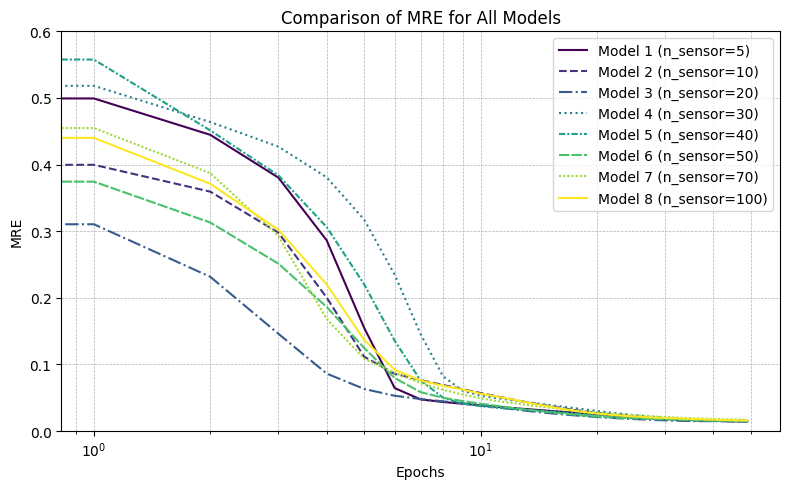

In [ ]:
plot_comparison_mre_all(trainers, num_sensors)